In [ ]:
import psi4
from qcportal import PortalClient
from pprint import pprint as pp
from qcelemental.models import Molecule
import qcelemental as qcel
from qcportal.singlepoint import SinglepointDataset, SinglepointDatasetEntry, QCSpecification
import pandas as pd
import numpy as np
import re

# need manybodydataset
from qcportal.manybody import ManybodyDataset, ManybodyDatasetEntry, ManybodyDatasetSpecification, ManybodySpecification
from pprint import pprint as pp

In [1]:
from setup_qcfractal import setup_qcarchive_qcfractal
import os

setup_qcarchive_qcfractal(
    QCF_BASE_FOLDER=os.path.join(os.getcwd(), "qcfractal"),
    start=False,
    reset=False,
    db_config={
        "name": None,
        "enable_security": "false",
        "allow_unauthenticated_read": None,
        "logfile": None,
        "loglevel": None,
        "service_frequency": 10,
        "max_active_services": None,
        "heartbeat_frequency": None,
        "log_access": None,
        "database": {
            "base_folder": None,
            "host": None,
            "port": 5432,
            "database_name": "qca",
            "username": None,
            "password": None,
            "own": None,
        },
        "api": {
            "host": None,
            "port": 7777,
            "secret_key": None,
            "jwt_secret_key": None,
        },
    },
    resources_config={
            "update_frequency": 5,
            "cores_per_worker": 8,
            "max_workers": 3,
            "memory_per_worker": 20,
    }
)

/home/amwalla3/gits/cybershuttle_demo/qcfractal

--------------------------------------------------------------------------------
Python executable:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/python
QCFractal version:  0.59
QCFractal alembic revision:  d5988aa750ae
pg_ctl path:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/pg_ctl
PostgreSQL server version:  PostgreSQL 17.4 on x86_64-conda-linux-gnu, compiled by x86_64-conda-linux-gnu-cc (conda-forge gcc 13.3.0-2) 13.3.0, 64-bit
--------------------------------------------------------------------------------


Displaying QCFractal configuration below
--------------------------------------------------------------------------------
access_log_keep: 0
allow_unauthenticated_read: true
api:
  extra_flask_options: null
  extra_waitress_options: null
  host: localhost
  jwt_access_token_expires: 3600
  jwt_refresh_token_expires: 86400
  jwt_secret_key: AT8imQ5QvhBQvgROhpvrxTrVERFNhbUEUK1nOEFRwNA
  num_threads_per_worker: 4
  port: 7777
  secret

In [ ]:
!qcfractal-server --config=`pwd`/qcfractal/qcfractal_config.yaml start > qcfractal_server.log & disown

# NOTE kill server when finished by running:
#     ps aux | grep qcfractal-server | awk '{ print $2 }'
#     kill -9 <PID>

In [ ]:
!qcfractal-compute-manager --config=`pwd`/qcfractal/resources.yml > qcfractal_compute.log & disown
# NOTE kill server when finished by running:;
#    ps aux | grep qcfractal-server | awk '{ print $2 }'
#    kill -9 <PID>

In [2]:
# Running a single job
client = PortalClient("http://localhost:7777", verify=False)
# for rec in client.query_records():
#     pp(rec)

mol = Molecule.from_data(
    """
     0 1
     O  -1.551007  -0.114520   0.000000
     H  -1.934259   0.762503   0.000000
     H  -0.599677   0.040712   0.000000
     --
     0 1
     O   1.350625   0.111469   0.000000
     H   1.680398  -0.373741  -0.758561
     H   1.680398  -0.373741   0.758561

     units angstrom
     no_reorient
     symmetry c1
"""
)

psi4.set_options(
    {"basis": "aug-cc-pvdz", "scf_type": "df", "e_convergence": 6, "freeze_core": True}
)

client.add_singlepoints(
    [mol],
    "psi4",
    driver="energy",
    method="b3lyp",
    basis="aug-cc-pvdz",
    keywords={"scf_type": "df", "e_convergence": 6, "freeze_core": True},
    tag="local",
)

# for rec in client.query_records():
#     pp(rec.dict)
#     pp(rec.error)

(InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0]),
 [1])

In [3]:
# Now create S22 Interaction Energy Dataset
from s22 import geoms, ref_IEs

assert len(geoms) == len(ref_IEs), "Number of geometries and reference interaction energies do not match"

# geoms is a list of qcelemental Molecule objects that can be used to create a
# QCArchive dataset
print(len(geoms), geoms)

22 [Molecule(name='H6N2', formula='H6N2', hash='3fadb04'), Molecule(name='H4O2', formula='H4O2', hash='49ecd61'), Molecule(name='C2H4O4', formula='C2H4O4', hash='cb6a49d'), Molecule(name='C2H6N2O2', formula='C2H6N2O2', hash='b1ca3e5'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='13c83b3'), Molecule(name='C10H11N3O', formula='C10H11N3O', hash='3b8e723'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='3520f9b'), Molecule(name='C2H8', formula='C2H8', hash='67d7d29'), Molecule(name='C4H8', formula='C4H8', hash='47f28b2'), Molecule(name='C7H10', formula='C7H10', hash='4810149'), Molecule(name='C12H12', formula='C12H12', hash='420be36'), Molecule(name='C8H8N4', formula='C8H8N4', hash='3072d92'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='9f67f10'), Molecule(name='C14H13N', formula='C14H13N', hash='00ea319'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='4af63d5'), Molecule(name='C4H6', formula='C4H6', hash='2f8f067'), Molecule(name='C6H8O', formula='C6H8O'

In [4]:
# Create client dataset

ds_name = 'S22-multipoles'

try:
    ds = client.add_dataset("singlepoint", ds_name,
                            f"Dataset to contain {ds_name}")
    print(f"Added {ds_name} as dataset")
    # Insert entries into dataset
    entry_list = []
    for idx, mol in enumerate(geoms):
        extras = {
            "name": 'S22-' + str(idx),
            "idx": idx,
        }
        mol = Molecule.from_data(mol.dict(), extras=extras)
        ent = SinglepointDatasetEntry(name=extras['name'], molecule=mol)
        entry_list.append(ent)
    ds.add_entries(entry_list)
    print(f"Added {len(entry_list)} molecules to dataset")
except Exception:
    ds = client.get_dataset("singlepoint", ds_name)
    print(f"Found {ds_name} dataset, using this instead")
    print(ds)

Found S22-multipoles dataset, using this instead
id=1 dataset_type='singlepoint' name='S22-multipoles' description='Dataset to contain S22-multipoles' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True


In [5]:
# Set the method and basis for lower requirements?
method, basis = "hf", "sto-3g"

# Set the QCSpecification (QM interaction energy in our case)
spec = QCSpecification(
    program="psi4",
    driver="energy",
    method=method,
    basis=basis,
    keywords={
        "d_convergence": 8,
        "dft_radial_points": 99,
        "dft_spherical_points": 590,
        "e_convergence": 10,
        "guess": "sad",
        "mbis_d_convergence": 9,
        "mbis_radial_points": 99,
        "mbis_spherical_points": 590,
        "scf_properties": ["mbis_charges", "MBIS_VOLUME_RATIOS"],
        "scf_type": "df",
    },
    protocols={"wavefunction": "orbitals_and_eigenvalues"},
)
ds.add_specification(name=f"psi4/{method}/{basis}", specification=spec)

InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0])

In [6]:
# Run the computations
ds.submit()
print(f"Submitted {ds_name} dataset")

Submitted S22-multipoles dataset


In [7]:
# Check the status of the dataset - can repeatedly run this to see the progress
ds.status()

{'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [8]:
# Create client dataset

ds_name_mb = 'S22-manybody'

try:
    ds_mb = client.add_dataset("manybody", ds_name_mb,
                            f"Dataset to contain {ds_name_mb}")
    print(f"Added {ds_name_mb} as dataset")
except Exception:
    ds_mb = client.get_dataset("manybody", ds_name_mb)
    print(f"Found {ds_name_mb} dataset, using this instead")
    print(ds)

# Insert entries into dataset

entry_list = []
for idx, mol in enumerate(geoms):
    print(mol)
    ent = ManybodyDatasetEntry(name=f"S22-IE-{idx}", initial_molecule=mol)
    entry_list.append(ent)
ds_mb.add_entries(entry_list)
print(f"Added {len(entry_list)} molecules to dataset")

# Set the method and basis for lower requirements?
method, basis = "hf", "sto-3g"

# Set the QCSpecification (QM interaction energy in our case)

qc_spec_mb = QCSpecification(
    program="psi4",
    driver="energy",
    method=method,
    basis=basis,
    keywords={
        "d_convergence": 8,
        "scf_type": "df",
    },
)

spec_mb = ManybodySpecification(
    program='qcmanybody',
    bsse_correction=['cp', 'nocp'],
    levels={
        1: qc_spec_mb,
        2: qc_spec_mb,
    },
)
print("spec_mb", spec_mb)

ds_mb.add_specification(name=f"psi4/{method}/{basis}", specification=spec_mb)

# Run the computations
ds_mb.submit()
print(f"Submitted {ds_name} dataset")

# Check the status of the dataset - can repeatedly run this to see the progress
ds_mb.status()

Found S22-manybody dataset, using this instead
id=1 dataset_type='singlepoint' name='S22-multipoles' description='Dataset to contain S22-multipoles' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True
Molecule(name='H6N2', formula='H6N2', hash='3fadb04')
Molecule(name='H4O2', formula='H4O2', hash='49ecd61')
Molecule(name='C2H4O4', formula='C2H4O4', hash='cb6a49d')
Molecule(name='C2H6N2O2', formula='C2H6N2O2', hash='b1ca3e5')
Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='13c83b3')
Molecule(name='C10H11N3O', formula='C10H11N3O', hash='3b8e723')
Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='3520f9b')
Molecule(name='C2H8', formula='C2H8', hash='67d7d29')
Molecule(name='C4H8', formula='C4H8', hash='47f28b2')
Molecule(name='C7H10', formula='C7H10', hash='4810149')
Molecule(name='C12H12'

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [9]:
ds_mb.status()

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [10]:
# Want multiple levels of theory

methods = [
    'hf', 'pbe', 'b3lyp',
]
basis_sets = [
    '6-31g*'
]

for method in methods:
    for basis in basis_sets:
        # Set the QCSpecification (QM interaction energy in our case)
        qc_spec_mb = QCSpecification(
            program="psi4",
            driver="energy",
            method=method,
            basis=basis,
            keywords={
                "d_convergence": 8,
                "scf_type": "df",
            },
        )

        spec_mb = ManybodySpecification(
            program='qcmanybody',
            bsse_correction=['cp'],
            levels={
                1: qc_spec_mb,
                2: qc_spec_mb,
            },
        )
        print("spec_mb", spec_mb)

        ds_mb.add_specification(name=f"psi4/{method}/{basis}", specification=spec_mb)

        # Run the computations
        ds_mb.submit()
        print(f"Submitted {ds_name} dataset")
# Check the status of the dataset - can repeatedly run this to see the progress
ds_mb.status()

spec_mb program='qcmanybody' levels={1: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>)), 2: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>))} bsse_correction=[<BSSECorrectionEnum.cp: 'cp'>] keywords=ManybodyKeywords(return_total_data=False) protocols={}
Submitted S22-multipoles dataset
spec_mb program='qcmanybody' levels={1

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}

In [11]:
pp(ds.status())
pp(ds_mb.status())

{'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22}}
{'psi4/b3lyp/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/hf/sto-3g': {<RecordStatusEnum.complete: 'complete'>: 22},
 'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 22}}


In [12]:
pp(ds)
pp(ds_mb)
pp(ds_mb.computed_properties)
# client.delete_dataset(dataset_id=2, delete_records=True)

SinglepointDataset(id=1, dataset_type='singlepoint', name='S22-multipoles', description='Dataset to contain S22-multipoles', tagline='', tags=[], group='default', visibility=True, provenance={}, default_tag='*', default_priority=<PriorityEnum.normal: 1>, owner_user=None, owner_group=None, metadata={}, extras={}, contributed_values_=None, attachments_=None, auto_fetch_missing=True)
ManybodyDataset(id=2, dataset_type='manybody', name='S22-manybody', description='Dataset to contain S22-manybody', tagline='', tags=[], group='default', visibility=True, provenance={}, default_tag='*', default_priority=<PriorityEnum.normal: 1>, owner_user=None, owner_group=None, metadata={}, extras={}, contributed_values_=None, attachments_=None, auto_fetch_missing=True)
{'psi4/b3lyp/6-31g*': ['results',
                       'mc_results',
                       'ret_energy',
                       'energy_body_dict',
                       'component_properties'],
 'psi4/hf/6-31g*': ['results',
            

In [13]:
# Multipole Molecule assemble
def assemble_multipole_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    charges = qcvars["mbis charges"]
    dipoles = qcvars["mbis dipoles"]
    quadrupoles = qcvars["mbis quadrupoles"]
    level_of_theory = f"{record_dict['specification']['method']}/{record_dict['specification']['basis']}"

    n = len(charges)

    charges = np.reshape(charges, (n, 1))
    dipoles = np.reshape(dipoles, (n, 3))
    quad = np.reshape(quadrupoles, (n, 3, 3))

    quad = [q[np.triu_indices(3)] for q in quad]
    quadrupoles = np.array(quad)
    multipoles = np.concatenate(
        [charges, dipoles, quadrupoles], axis=1)
    return (
    record.molecule,
    qcvars['mbis volume ratios'],
    qcvars['mbis valence widths'],
    qcvars['mbis radial moments <r^2>'],
    qcvars['mbis radial moments <r^3>'],
    qcvars['mbis radial moments <r^4>'],
    record.molecule.atomic_numbers,
    record.molecule.geometry * qcel.constants.bohr2angstroms,
    multipoles,
    int(record.molecule.molecular_charge),
    record.molecule.molecular_multiplicity,
    )

def assemble_multipole_data_value_names():
    return [
        'qcel_molecule',
        "volume ratios",
        "valence widths",
        "radial moments <r^2>",
        "radial moments <r^3>",
        "radial moments <r^4>",
        "Z",
        "R",
        "cartesian_multipoles",
        "TQ",
        "molecular_multiplicity"
    ]

df = ds.compile_values(
    value_call=assemble_multipole_data,
    value_names=assemble_multipole_data_value_names(),
    unpack=True,
)
print(df)
pp(df.columns.tolist())
print(df['psi4/hf/sto-3g'])
pp(df['psi4/hf/sto-3g'].columns.tolist())
df_hf_sto3g = df['psi4/hf/sto-3g']
print(df_hf_sto3g.columns.tolist())
print(df_hf_sto3g)

specification                                     psi4/hf/sto-3g  ...                       
                                                   qcel_molecule  ... molecular_multiplicity
entry                                                             ...                       
S22-0          Molecule(name='H6N2', formula='H6N2', hash='3f...  ...                      1
S22-1          Molecule(name='H4O2', formula='H4O2', hash='49...  ...                      1
S22-10         Molecule(name='C12H12', formula='C12H12', hash...  ...                      1
S22-11         Molecule(name='C8H8N4', formula='C8H8N4', hash...  ...                      1
S22-12         Molecule(name='C8H8N4O4', formula='C8H8N4O4', ...  ...                      1
S22-13         Molecule(name='C14H13N', formula='C14H13N', ha...  ...                      1
S22-14         Molecule(name='C10H11N7O2', formula='C10H11N7O...  ...                      1
S22-15         Molecule(name='C4H6', formula='C4H6', hash='2f...  ... 

In [14]:
h2kcalmol = qcel.constants.hartree2kcalmol

def assemble_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    level_of_theory = f"{record_dict['specification']['levels'][2]['method']}/{record_dict['specification']['levels'][2]['basis']}"
    CP_IE = qcvars['results']['cp_corrected_interaction_energy'] * h2kcalmol
    NOCP_IE = qcvars['results'].get('nocp_corrected_interaction_energy', np.nan) * h2kcalmol
    return (
    record.initial_molecule,
    CP_IE,
    NOCP_IE,
    record.initial_molecule.atomic_numbers,
    record.initial_molecule.geometry * qcel.constants.bohr2angstroms,
    int(record.initial_molecule.molecular_charge),
    record.initial_molecule.molecular_multiplicity,
    )

def assemble_data_value_names():
    return [
        'qcel_molecule',
        "CP_IE",
        "NOCP_IE",
        "Z",
        "R",
        "TQ",
        "molecular_multiplicity"
    ]

df_mb = ds_mb.compile_values(
    value_call=assemble_data,
    value_names=assemble_data_value_names(),
    unpack=True,
)

print(df_mb)

specification                                  psi4/b3lyp/6-31g*  ...        psi4/pbe/6-31g*
                                                   qcel_molecule  ... molecular_multiplicity
entry                                                             ...                       
S22-IE-0       Molecule(name='H6N2', formula='H6N2', hash='3f...  ...                      1
S22-IE-1       Molecule(name='H4O2', formula='H4O2', hash='49...  ...                      1
S22-IE-10      Molecule(name='C12H12', formula='C12H12', hash...  ...                      1
S22-IE-11      Molecule(name='C8H8N4', formula='C8H8N4', hash...  ...                      1
S22-IE-12      Molecule(name='C8H8N4O4', formula='C8H8N4O4', ...  ...                      1
S22-IE-13      Molecule(name='C14H13N', formula='C14H13N', ha...  ...                      1
S22-IE-14      Molecule(name='C10H11N7O2', formula='C10H11N7O...  ...                      1
S22-IE-15      Molecule(name='C4H6', formula='C4H6', hash='2f...  ... 

In [15]:
from cdsg_plot import error_statistics

pp(df_mb.columns.tolist())

df_plot = pd.DataFrame(
    {
        "qcel_molecule": df_mb["psi4/hf/sto-3g"]["qcel_molecule"],
        "HF/6-31G*": df_mb["psi4/hf/6-31g*"]["CP_IE"],
        "PBE/6-31G*": df_mb["psi4/pbe/6-31g*"]["CP_IE"],
        "B3LYP/6-31G*": df_mb["psi4/b3lyp/6-31g*"]["CP_IE"],
        'reference': ref_IEs,
    }
)
id = [int(i[7:]) for i in df_plot.index]
df_plot['id'] = id
df_plot.sort_values(by='id', inplace=True, ascending=True)
df_plot['reference'] = ref_IEs
df_plot['HF/6-31G* error'] = (df_plot['HF/6-31G*'] - df_plot['reference']).astype(float)
df_plot['PBE/6-31G* error'] = (df_plot['PBE/6-31G*'] - df_plot['reference']).astype(float)
df_plot['B3LYP/6-31G* error'] = (df_plot['B3LYP/6-31G*'] - df_plot['reference']).astype(float)
pd.set_option('display.max_rows', None)
print(df_plot)
print(df_plot[['HF/6-31G* error', 'PBE/6-31G* error', 'B3LYP/6-31G* error']].describe())

[('psi4/b3lyp/6-31g*', 'qcel_molecule'),
 ('psi4/hf/6-31g*', 'qcel_molecule'),
 ('psi4/hf/sto-3g', 'qcel_molecule'),
 ('psi4/pbe/6-31g*', 'qcel_molecule'),
 ('psi4/b3lyp/6-31g*', 'CP_IE'),
 ('psi4/hf/6-31g*', 'CP_IE'),
 ('psi4/hf/sto-3g', 'CP_IE'),
 ('psi4/pbe/6-31g*', 'CP_IE'),
 ('psi4/b3lyp/6-31g*', 'NOCP_IE'),
 ('psi4/hf/6-31g*', 'NOCP_IE'),
 ('psi4/hf/sto-3g', 'NOCP_IE'),
 ('psi4/pbe/6-31g*', 'NOCP_IE'),
 ('psi4/b3lyp/6-31g*', 'Z'),
 ('psi4/hf/6-31g*', 'Z'),
 ('psi4/hf/sto-3g', 'Z'),
 ('psi4/pbe/6-31g*', 'Z'),
 ('psi4/b3lyp/6-31g*', 'R'),
 ('psi4/hf/6-31g*', 'R'),
 ('psi4/hf/sto-3g', 'R'),
 ('psi4/pbe/6-31g*', 'R'),
 ('psi4/b3lyp/6-31g*', 'TQ'),
 ('psi4/hf/6-31g*', 'TQ'),
 ('psi4/hf/sto-3g', 'TQ'),
 ('psi4/pbe/6-31g*', 'TQ'),
 ('psi4/b3lyp/6-31g*', 'molecular_multiplicity'),
 ('psi4/hf/6-31g*', 'molecular_multiplicity'),
 ('psi4/hf/sto-3g', 'molecular_multiplicity'),
 ('psi4/pbe/6-31g*', 'molecular_multiplicity')]
Index(['S22-IE-0', 'S22-IE-1', 'S22-IE-10', 'S22-IE-11', 'S22-IE-12'

Plotting S22-IE.png
S22-IE_violin.png


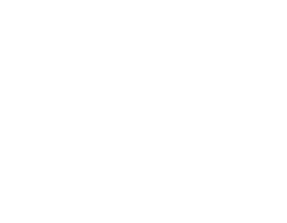

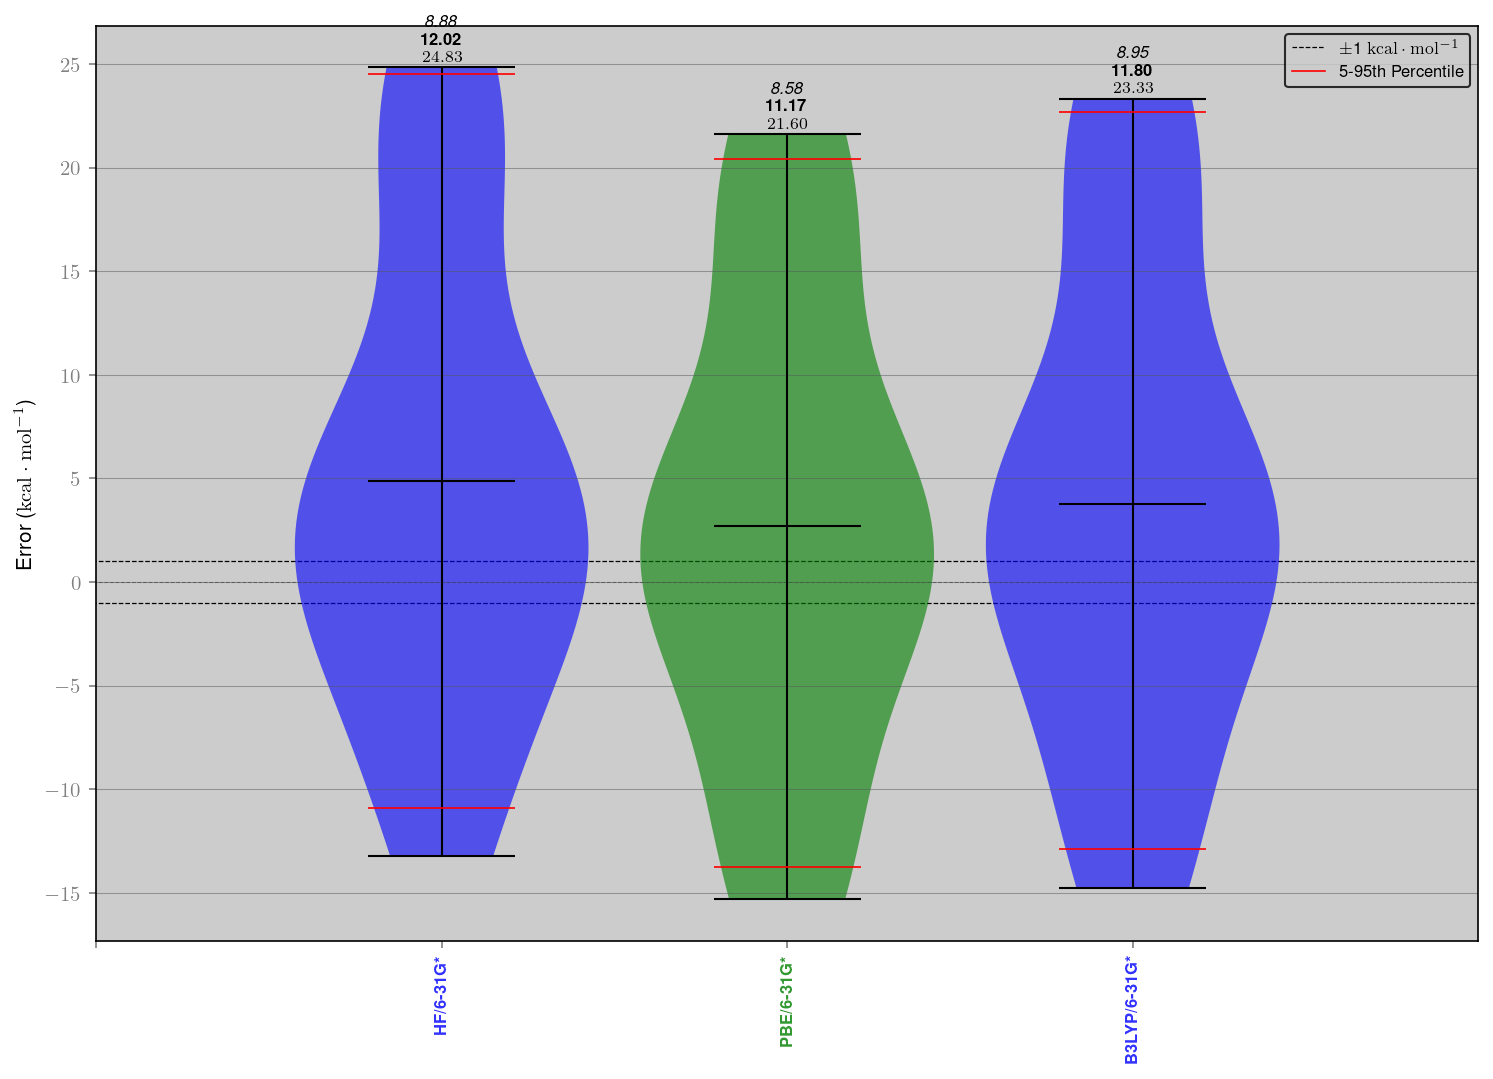

In [16]:
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "B3LYP/6-31G*": "B3LYP/6-31G* error",
    },
    output_filename="S22-IE.png",
    figure_size=(8, 6),
)

In [17]:
import apnet_pt

predicted_charges, predicted_dipoles, predicted_quadruples = apnet_pt.pretrained_models.atom_model_predict(
    mols=df_hf_sto3g['qcel_molecule'].tolist(),
    compile=False,
)
# Printing out predicted multipoles from pre-trained models
print(df_hf_sto3g['qcel_molecule'][0])
print(f"{predicted_charges[0] = }")
print(f"{predicted_dipoles[0] = }")
print(f"{predicted_quadruples[0] = }")

apnet2_ies_predicted = apnet_pt.pretrained_models.apnet2_model_predict(
    mols=df_hf_sto3g['qcel_molecule'].tolist(),
    compile=False,
)
# [[total, eletrostatic, induction, exchange, dispersion]]
print(apnet2_ies_predicted[0])

running on the CPU
Processing mols...
Predicting...
Molecule(name='H6N2', formula='H6N2', hash='3fadb04')
predicted_charges[0] = array([-0.90112876,  0.29432517,  0.29432516,  0.31247842, -0.9011288 ,
        0.29432516])
predicted_dipoles[0] = array([[ 0.02599126, -0.06312444, -0.00012491],
       [-0.02250877, -0.00536389, -0.03083978],
       [-0.02250877, -0.00536389,  0.03058995],
       [ 0.0280342 ,  0.01370036, -0.00012492],
       [-0.0262411 ,  0.06287461, -0.00012492],
       [ 0.02225894,  0.00511407, -0.03083978]])
predicted_quadruples[0] = array([[[ 1.13387983e-01,  8.84185694e-02,  1.02765486e-04],
        [ 8.84185694e-02, -1.60407102e-01,  1.02761760e-04],
        [ 1.02765486e-04,  1.02761760e-04,  4.70191199e-02]],

       [[ 2.64675869e-04,  6.53989241e-04, -3.29993479e-04],
        [ 6.53989241e-04, -7.19828950e-04, -7.54192844e-04],
        [-3.29993479e-04, -7.54192844e-04,  4.55152942e-04]],

       [[ 2.64675403e-04,  6.53992593e-04,  5.35535812e-04],
        [

Plotting S22-IE-AP2.png
S22-IE-AP2_violin.png


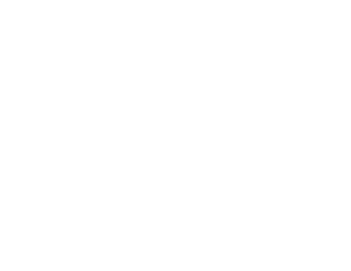

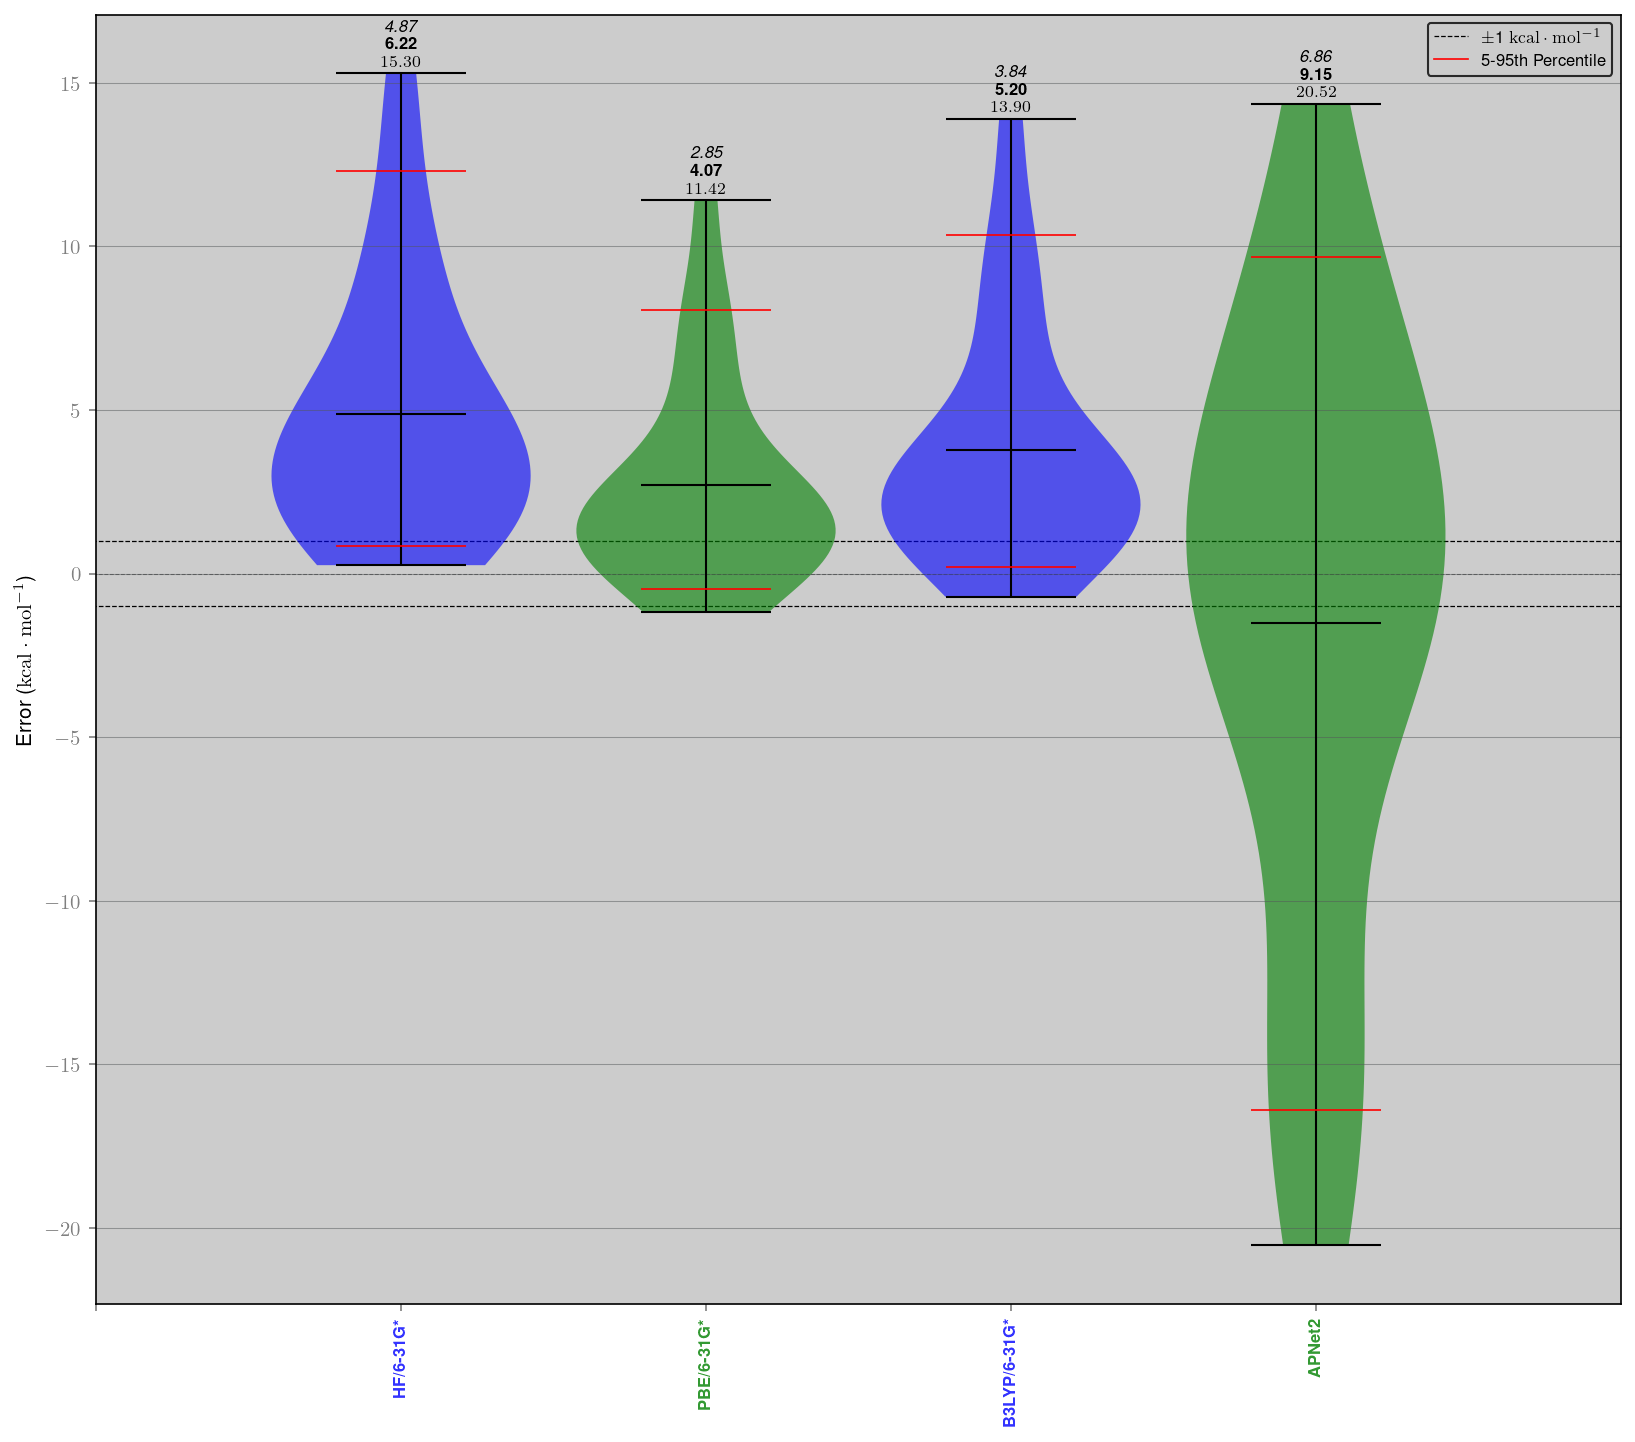

In [18]:
# AP-Net2 IE
df_plot['APNet2'] = apnet2_ies_predicted[:, 0]
df_plot['APNet2 error'] = (df_plot['APNet2'] - df_plot['reference']).astype(float)
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "B3LYP/6-31G*": "B3LYP/6-31G* error",
        "APNet2": "APNet2 error",
    },
    output_filename="S22-IE-AP2.png",
    figure_size=(4, 4),
)

In [19]:
# Training models on new QM data for Transfer Learning Task

from apnet_pt import pairwise_datasets

print(
    df_plot['qcel_molecule'].tolist(),
    df_plot['PBE/6-31G*'].tolist(),
)
print(len(df_plot['qcel_molecule'].tolist()))

ds = pairwise_datasets.apnet2_module_dataset(
    root="data_dir",
    spec_type=None,
    atom_model=apnet_pt.AtomModels.ap2_atom_model.AtomModel().set_pretrained_model(model_id=0),
    qcel_molecules=df_plot['qcel_molecule'].tolist(),
    energy_labels=df_plot['PBE/6-31G*'].tolist(),
    skip_compile=True,
    force_reprocess=True,
    atomic_batch_size=4,
    prebatched=False,
    in_memory=True,
    batch_size=2,
    # datapoint_storage_n_objects=4,
)
print("APNet2 dataset created")
print(ds)
print(ds.data)

[Molecule(name='H6N2', formula='H6N2', hash='3fadb04'), Molecule(name='H4O2', formula='H4O2', hash='49ecd61'), Molecule(name='C2H4O4', formula='C2H4O4', hash='cb6a49d'), Molecule(name='C2H6N2O2', formula='C2H6N2O2', hash='b1ca3e5'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='13c83b3'), Molecule(name='C10H11N3O', formula='C10H11N3O', hash='3b8e723'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='3520f9b'), Molecule(name='C2H8', formula='C2H8', hash='67d7d29'), Molecule(name='C4H8', formula='C4H8', hash='47f28b2'), Molecule(name='C7H10', formula='C7H10', hash='4810149'), Molecule(name='C12H12', formula='C12H12', hash='420be36'), Molecule(name='C8H8N4', formula='C8H8N4', hash='3072d92'), Molecule(name='C8H8N4O4', formula='C8H8N4O4', hash='9f67f10'), Molecule(name='C14H13N', formula='C14H13N', hash='00ea319'), Molecule(name='C10H11N7O2', formula='C10H11N7O2', hash='4af63d5'), Molecule(name='C4H6', formula='C4H6', hash='2f8f067'), Molecule(name='C6H8O', formula='C6H8O', h

In [20]:
# Transfer Learning APNet2 model on computed QM data
from apnet_pt.AtomPairwiseModels.apnet2 import APNet2Model

ap2 = APNet2Model(dataset=ds).set_pretrained_model(model_id=0)
print(ap2)

running on the CPU
self.dataset=apnet2_module_dataset(18)


In [21]:
print(ds)
ap2.train(
    n_epochs=50,
    transfer_learning=True,
    skip_compile=True,
    model_path="apnet2_transfer_learning.pt",
)
print(ap2)

apnet2_module_dataset(18)
Saving training results to...
apnet2_transfer_learning.pt
~~ Training APNet2Model ~~
    Training on 16 samples, Testing on 2 samples

Network Hyperparameters:
  self.model.n_message=3
  self.model.n_neuron=128
  self.model.n_embed=8
  self.model.n_rbf=8
  self.model.r_cut=5.0
  self.model.r_cut_im=8.0

Training Hyperparameters:
  n_epochs=50
  lr=0.0005

  lr_decay=None

  batch_size=2
Running single-process training
                                       Total
  (Pre-training) (0.36   s)  MAE:   4.200/5.925  
  EPOCH:    0 (0.53   s)  MAE:   3.673/2.167   *
  EPOCH:    1 (0.65   s)  MAE:   2.750/2.682    
  EPOCH:    2 (0.55   s)  MAE:   2.177/2.498    
  EPOCH:    3 (0.48   s)  MAE:   1.741/2.319   *
  EPOCH:    4 (0.37   s)  MAE:   1.495/2.227   *
  EPOCH:    5 (0.36   s)  MAE:   1.349/2.243    
  EPOCH:    6 (0.35   s)  MAE:   1.096/2.356    
  EPOCH:    7 (0.37   s)  MAE:   1.183/2.307    
  EPOCH:    8 (0.34   s)  MAE:   0.987/2.336    
  EPOCH:    9 (0

Plotting S22-IE-AP2.png
S22-IE-AP2_violin.png


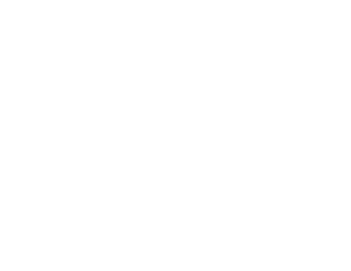

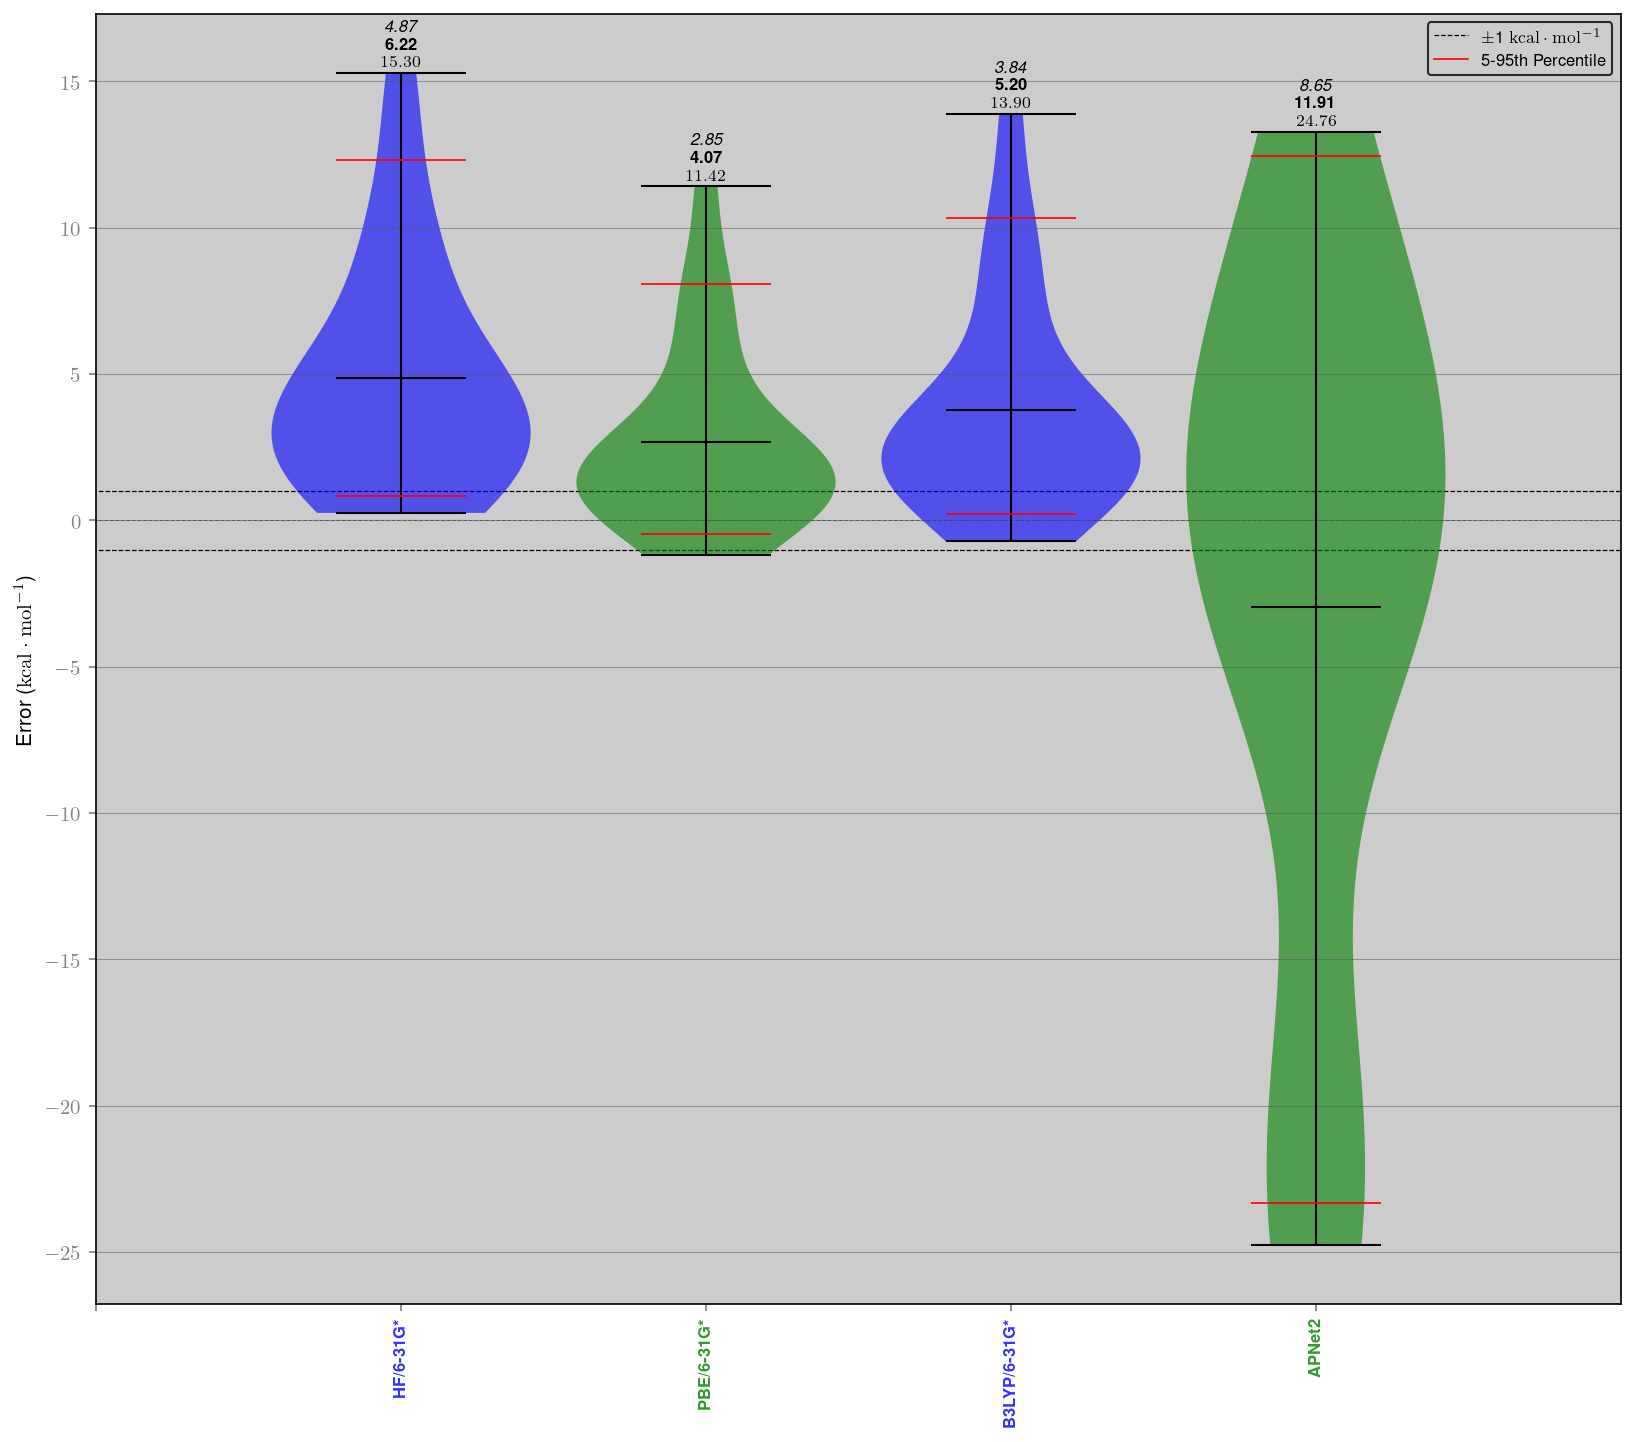

In [22]:
# AP-Net2 IE
apnet2_ies_predicted = ap2.predict_qcel_mols(
    mols=df_hf_sto3g['qcel_molecule'].tolist(),
)
df_plot['APNet2'] = apnet2_ies_predicted[:, 0]
df_plot['APNet2 error'] = (df_plot['APNet2'] - df_plot['reference']).astype(float)

error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "B3LYP/6-31G*": "B3LYP/6-31G* error",
        "APNet2": "APNet2 error",
    },
    output_filename="S22-IE-AP2.png",
    figure_size=(4, 4),
)

In [ ]:
# Be careful with this for it can corrupt running status...
# !ps aux | grep qcfractal | awk '{ print $2 }' | xargs kill -9